# Import software libraries and load the dataset #

In [1]:
import sys                             # Read system parameters.
import os                              # Interact with the operating system.
import numpy as np                     # Work with multi-dimensional arrays and matrices.
import pandas as pd                    # Manipulate and analyze data.
import matplotlib                      # Create 2D charts.
import matplotlib.pyplot as plt
import seaborn as sb                   # Perform data visualization.
import scipy as sp                     # Perform scientific computing and advanced mathematics.
import sklearn                         # Perform data mining and analysis.
from time import time                  # Calculate training time.

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sb.__version__))
print('- SciPy {}'.format(sp.__version__))
print('- scikit-learn {}\n'.format(sklearn.__version__))

# Load the dataset.
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "titanic_data")
print('Data files in this project:', os.listdir(DATA_PATH))
data_raw_file = os.path.join(DATA_PATH, 'train.csv')
data_raw = pd.read_csv(data_raw_file)
print('Loaded {} records from {}.'.format(len(data_raw), data_raw_file))

Libraries used in this project:
- Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
- NumPy 1.16.2
- pandas 0.24.2
- Matplotlib 3.0.3
- Seaborn 0.9.0
- SciPy 1.2.1
- scikit-learn 0.20.3

Data files in this project: ['train.csv', 'test.csv']
Loaded 891 records from ./titanic_data/train.csv.


# Split the datasets

In [2]:
# Separate training and test sets already exist.
# A validation set will be split off from the training sets.

from sklearn.model_selection import train_test_split

# 'Survived' is the dependent variable (value to be predicted), so it will be
# removed from the training data and put into a separate DataFrame for labels.
label_columns = ['Survived']

training_columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

# Split the training and validation datasets and their labels.
X_train, X_val, y_train, y_val = train_test_split(data_raw[training_columns],
                                                                            data_raw[label_columns],
                                                                            random_state = 1912)

print('The training and validation datasets and labels have been split.')

The training and validation datasets and labels have been split.


# Look for categorical features that need to be one-hot encoded

In [3]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
439,440,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
617,618,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S
242,243,2,"Coleridge, Mr. Reginald Charles",male,29.0,0,0,W./C. 14263,10.5000,NaN,S
82,83,3,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q
398,399,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S


# Perform common preparation on the training and validation sets

In [4]:
# Perform common cleaning and feature engineering tasks on datasets.
def prep_dataset(dataset):
    
    # PROVIDE MISSING VALUES
    
    # Fill missing Age values with the median age.
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # Fill missing Fare values with the median fare.
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

    # Fill missing Embarked values with the mode.
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    # ONE-HOT ENCODING
    
    cols = ['Pclass', 'Sex', 'Embarked']
    
    for i in cols:
        dummies = pd.get_dummies(dataset[i], prefix = i, drop_first = False)
        dataset = pd.concat([dataset, dummies], axis = 1)

    return dataset

X_train = prep_dataset(X_train.copy())

X_val = prep_dataset(X_val.copy())

print('The dataset has been cleaned and prepared.')

The dataset has been cleaned and prepared.


# Drop columns that won't be used for training

In [5]:
# Drop unused columns from datasets.
def drop_unused(dataset):
        
    dataset = dataset.drop(['PassengerId'], axis = 1)
    dataset = dataset.drop(['Cabin'], axis = 1)
    dataset = dataset.drop(['Ticket'], axis = 1)
    dataset = dataset.drop(['Name'], axis = 1)

    # These have been replaced with one-hot encoding.
    dataset = dataset.drop(['Pclass'], axis = 1)
    dataset = dataset.drop(['Sex'], axis = 1)
    dataset = dataset.drop(['Embarked'], axis = 1)
    
    return dataset

X_train = drop_unused(X_train.copy())

X_val = drop_unused(X_val.copy())

print('Columns that will not be used for training have been dropped.')

Columns that will not be used for training have been dropped.


# Preview current training data

In [6]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
439,31.0,0,0,10.5000,0,1,0,0,1,0,0,1
617,26.0,1,0,16.1000,0,0,1,1,0,0,0,1
242,29.0,0,0,10.5000,0,1,0,0,1,0,0,1
82,27.5,0,0,7.7875,0,0,1,1,0,0,1,0
398,23.0,0,0,10.5000,0,1,0,0,1,0,0,1


# Create a basic decision tree model

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 1912)
start = time()
tree.fit(X_train, np.ravel(y_train))
end = time()
train_time = (end - start) * 1000

prediction = tree.predict(X_val)

# Score using the validation data.
score = tree.score(X_val, y_val)

print('Decision tree model took {:.2f} milliseconds to fit.'.format(train_time))
print('Accuracy: {:.0f}%'.format(score * 100))

Decision tree model took 2.30 milliseconds to fit.
Accuracy: 80%


# Visualize the decision tree structure

In [8]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, display 
import pydotplus as pdotp

def plot_tree(model, image):
    dot_data = StringIO()
    export_graphviz(model, out_file = dot_data, 
                    filled = True,
                    rounded = True,
                    special_characters = True, 
                    feature_names = X_train.columns.values.tolist(),
                    class_names = ['0', '1'])

    graph = pdotp.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(image)
    Image(graph.create_png())
    
print('A function to plot the decision tree structure has been defined.')

A function to plot the decision tree structure has been defined.


# Compute accuracy, precision, recall, and F<sub>1</sub> score

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def model_scores(y, prediction):
    acc = accuracy_score(y, prediction)
    print('Accuracy: {:.0f}%'.format(np.round(acc * 100)))
    
    precision = precision_score(y, prediction)
    print('Precision: {:.0f}%'.format(np.round(precision * 100)))
    
    recall = recall_score(y, prediction)
    print('Recall: {:.0f}%'.format(np.round(recall * 100)))
    
    f1 = f1_score(y, prediction)
    print('F1: {:.0f}%'.format(np.round(f1 * 100)))
    
print('A function to compute the model scores has been defined.')

A function to compute the model scores has been defined.


# Generate a ROC curve and compute the AUC

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc(y, prediction_proba):
    fpr, tpr, thresholds = roc_curve(y, prediction_proba)
    
    plt.plot(fpr, tpr);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('ROC Curve');
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.grid(True);
    
    auc = roc_auc_score(y, prediction_proba)
    print('Area Under Curve: {:.2f}'.format(auc))
    
print('A function to generate the ROC curve and compute AUC has been defined.')

A function to generate the ROC curve and compute AUC has been defined.


# Generate a precision–recall curve and compute the average precision

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def prc(y, prediction_proba):
    precision, recall, thresholds = precision_recall_curve(y, prediction_proba)
    
    plt.plot(recall, precision);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('Precision–Recall Curve');
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.grid(True);
    
    ap = average_precision_score(y, prediction_proba)
    print('Average Precision: {:.2f}'.format(ap))
    
print('A function to generate the PRC and compute average precision has been defined.')

A function to generate the PRC and compute average precision has been defined.


# Evaluate the initial decision tree model

In [12]:
# Install required library.
!conda install --yes graphviz==2.40.1

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz==2.40.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    cairo-1.16.0               |    hcf35c78_1003         1.5 MB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_0         143 KB  conda-forge
    expat-2.2.9                |       he1b5a44_2         191 KB  conda-forge
    fontconfig-2.13.1          |    h86ecdb6_1001

libiconv-1.16        | 1.4 MB    | ##################################### | 100% 
xorg-libxpm-3.5.13   | 63 KB     | ##################################### | 100% 
libxcb-1.13          | 396 KB    | ##################################### | 100% 
xorg-kbproto-1.0.7   | 26 KB     | ##################################### | 100% 
pango-1.42.4         | 521 KB    | ##################################### | 100% 
xorg-libx11-1.6.12   | 917 KB    | ##################################### | 100% 
xorg-libsm-1.2.3     | 25 KB     | ##################################### | 100% 
pixman-0.38.0        | 594 KB    | ##################################### | 100% 
cairo-1.16.0         | 1.5 MB    | ##################################### | 100% 
gettext-0.19.8.1     | 3.6 MB    | ##################################### | 100% 
libuuid-2.32.1       | 26 KB     | ##################################### | 100% 
libtool-2.4.6        | 497 KB    | ##################################### | 100% 
Preparing transaction: done


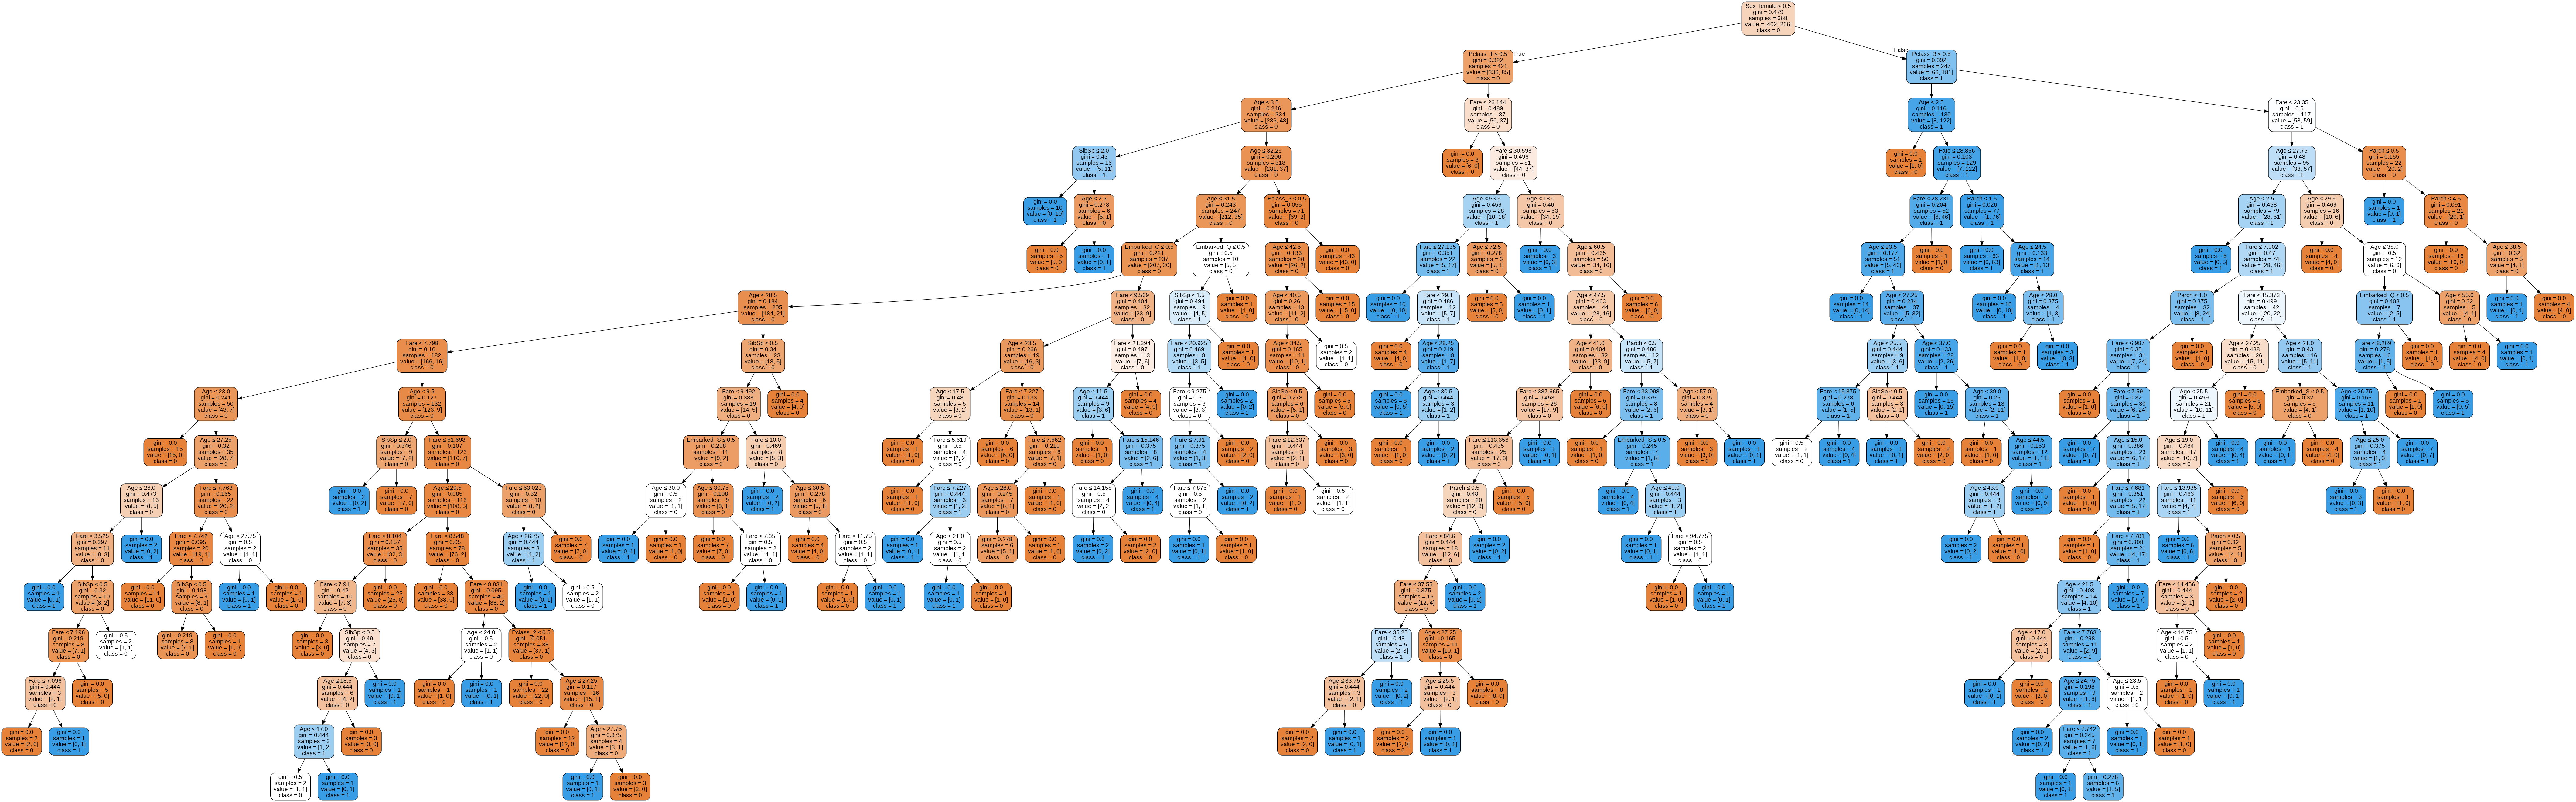

In [13]:
plot_tree(tree, 'titanic.png')
display(Image('titanic.png'))

In [14]:
initial_predict = tree.predict(X_val)

model_scores(y_val, initial_predict)

Accuracy: 80%
Precision: 74%
Recall: 63%
F1: 68%


Area Under Curve: 0.76


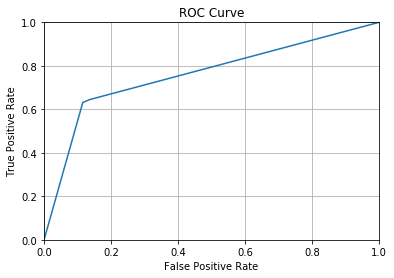

In [15]:
initial_predict_proba = tree.predict_proba(X_val)

roc(y_val, initial_predict_proba[:, 1])

Average Precision: 0.60


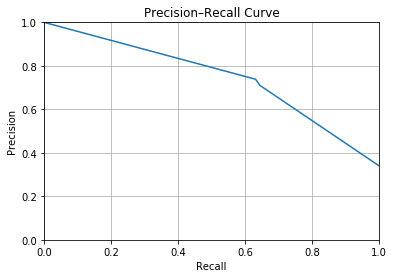

In [16]:
prc(y_val, initial_predict_proba[:, 1])

# Performing pre-pruning on the decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

pruned_tree = DecisionTreeClassifier(max_depth = 4, random_state = 1912)
start = time()
pruned_tree.fit(X_train, np.ravel(y_train))
end = time()
train_time = (end - start) * 1000

prediction = pruned_tree.predict(X_val)

# Score using the validation data.
score = pruned_tree.score(X_val, y_val)

print('Decision tree model took {:.2f} milliseconds to fit.'.format(train_time))
print('Accuracy: {:.0f}%'.format(score * 100))

Decision tree model took 2.15 milliseconds to fit.
Accuracy: 82%


# Evaluate the pruned decision tree model

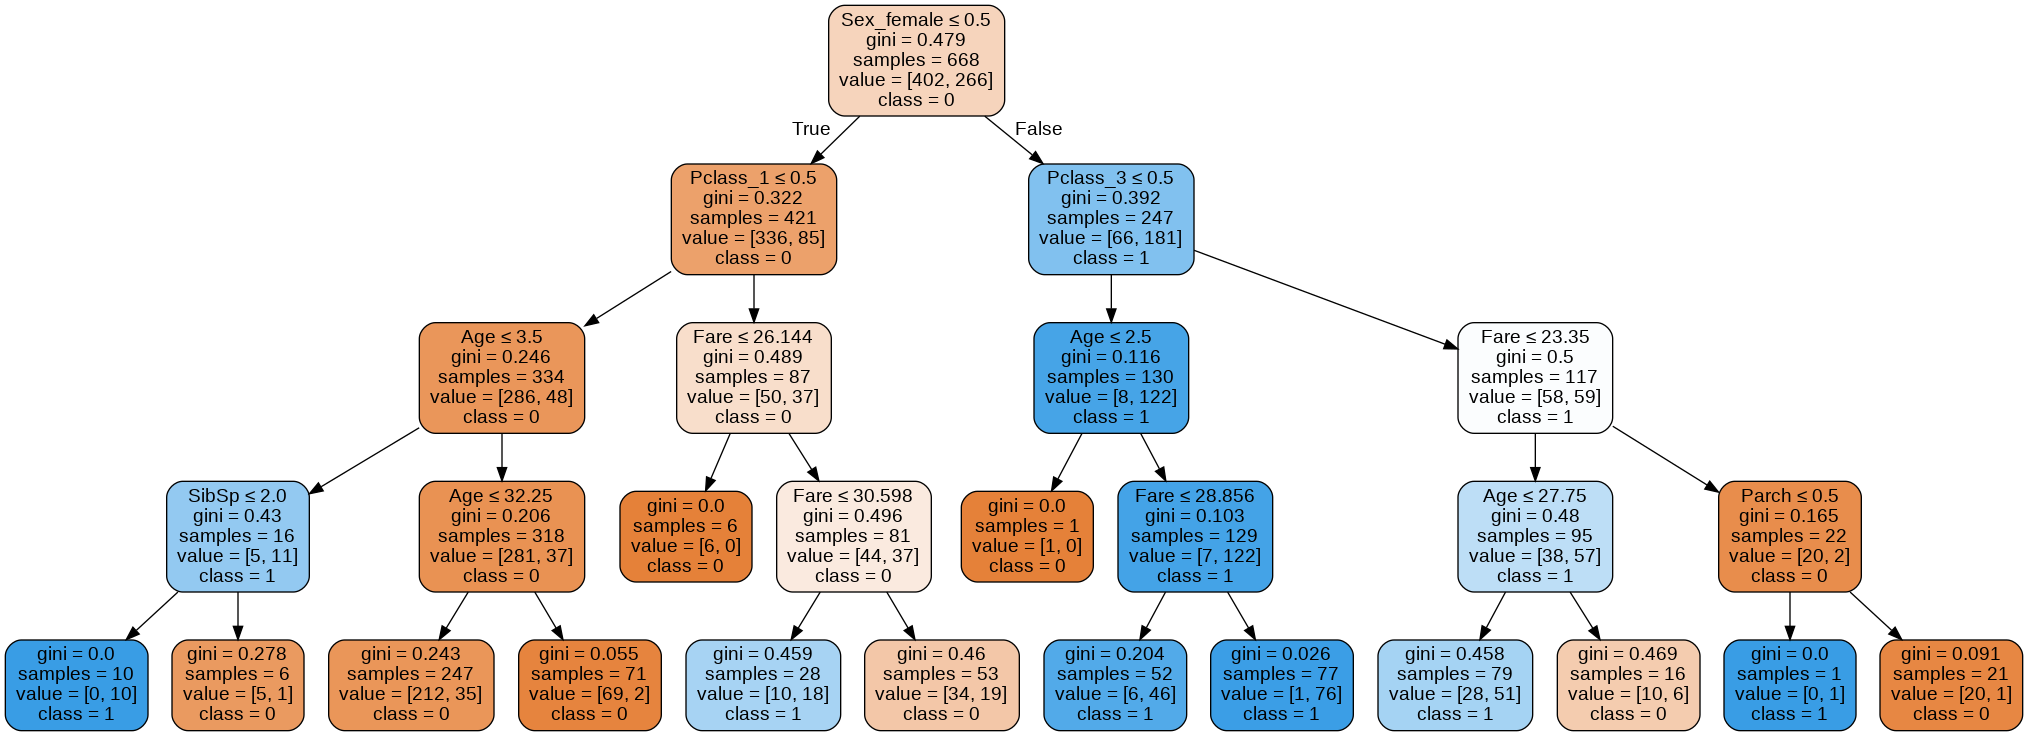

In [18]:
plot_tree(pruned_tree, 'titanic_pruned.png')
display(Image('titanic_pruned.png'))

In [19]:
pruned_predict = pruned_tree.predict(X_val)

model_scores(y_val, pruned_predict)

Accuracy: 82%
Precision: 82%
Recall: 59%
F1: 69%


Area Under Curve: 0.83


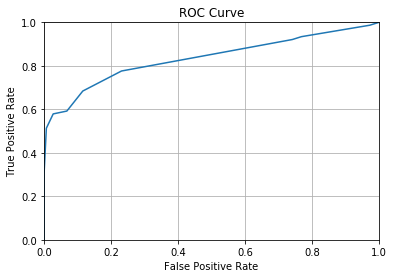

In [20]:
pruned_predict_proba = pruned_tree.predict_proba(X_val)

roc(y_val, pruned_predict_proba[:, 1])

Average Precision: 0.79


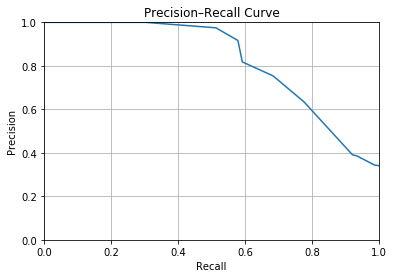

In [21]:
prc(y_val, pruned_predict_proba[:, 1])

# Fit a decision tree model using randomized search with cross-validation

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

dist = {'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': sp_randint(2, 10),
        'min_samples_split': sp_randint(5, 100),
        'min_samples_leaf': sp_randint(5, 100)}

search = RandomizedSearchCV(tree, param_distributions = dist, n_iter = 500, 
                            scoring = 'f1', cv = 5, iid = False, random_state = 1912)
search.fit(X_train, np.ravel(y_train));
optimized_tree = search.best_estimator_

print(search.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 78, 'splitter': 'best'}


# Evaluate the optimized model

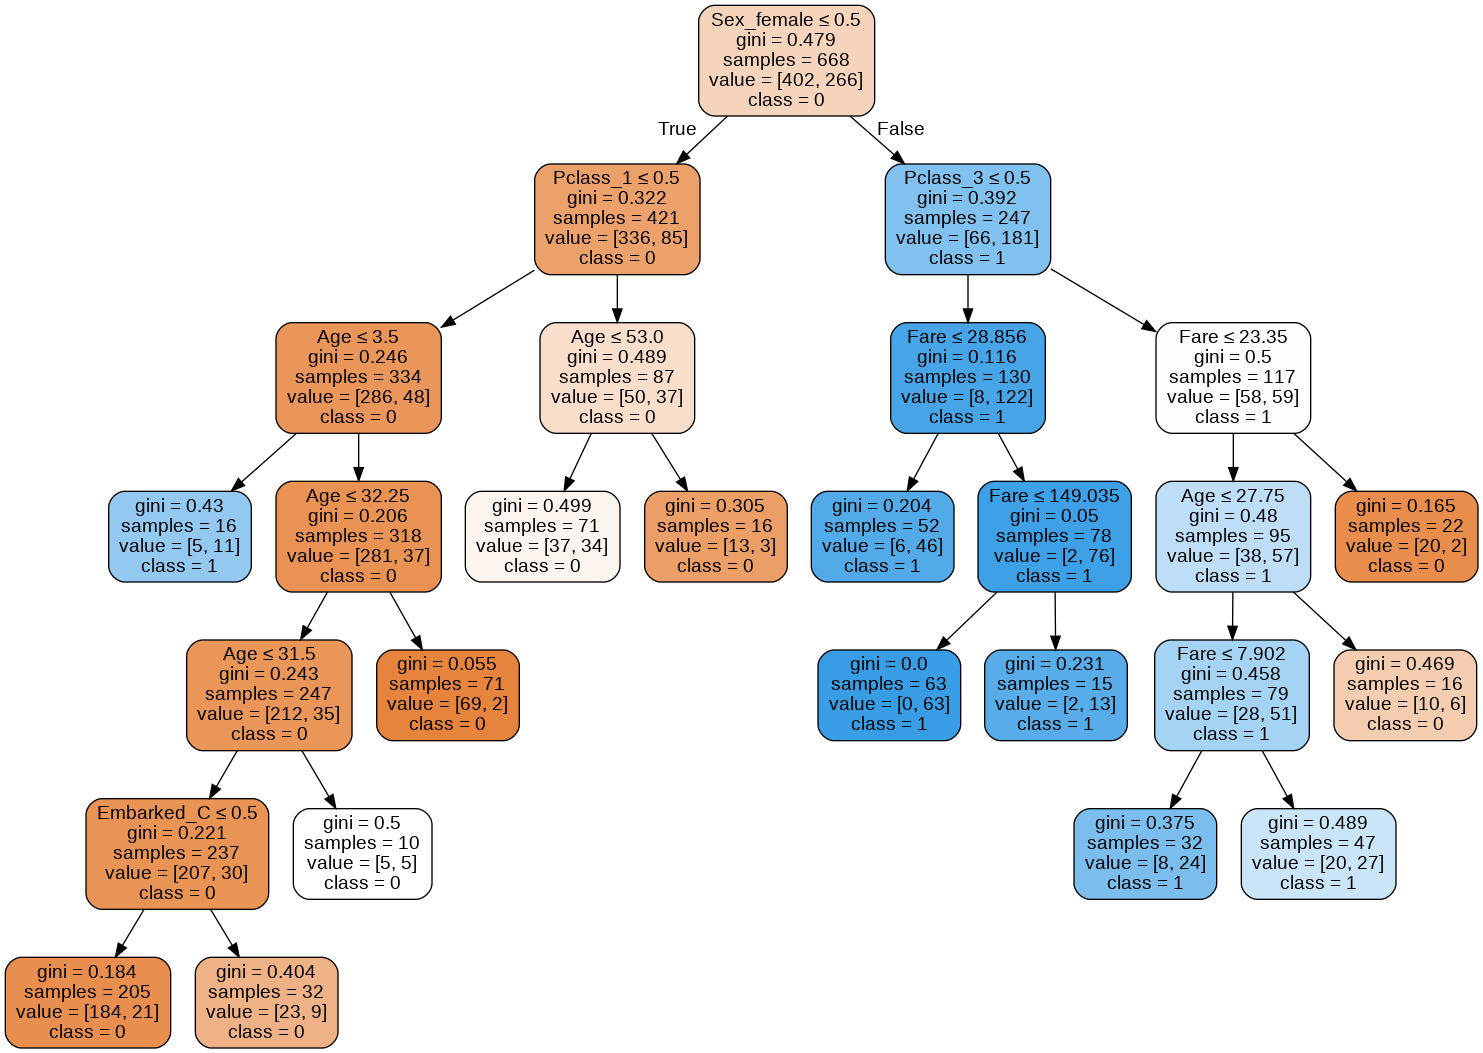

In [23]:
plot_tree(optimized_tree, 'titanic_optimized.png')
display(Image('titanic_optimized.png'))

In [24]:
optimized_predict = optimized_tree.predict(X_val)

model_scores(y_val, optimized_predict)

Accuracy: 84%
Precision: 92%
Recall: 59%
F1: 72%


Area Under Curve: 0.84


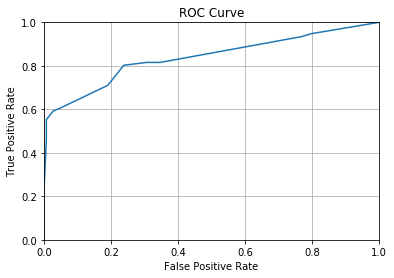

In [25]:
optimized_predict_proba = optimized_tree.predict_proba(X_val)

roc(y_val, optimized_predict_proba[:, 1])

Average Precision: 0.80


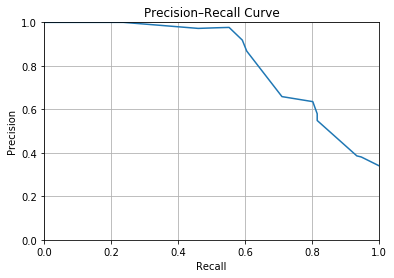

In [26]:
prc(y_val, optimized_predict_proba[:, 1])